# Gradient Matching Attack on a Pytorch Classifier

In this notebook, we will learn how to use ART to run a clean-label gradient matching poisoning attack on a neural network trained with Pytorch. We will be training our data on a subset of the CIFAR-10 dataset. The methods described are derived from [this paper](https://arxiv.org/abs/2009.02276) by Geiping, et. al. 2020.

## Train a model to attack

In this example, we use a RESNET50 model on the CIFAR dataset.

In [6]:
import numpy as np
import os, sys
import tqdm
from tqdm import trange

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)

from art.estimators.classification import PyTorchClassifier
from art.utils import load_cifar10

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

(x_train, y_train), (x_test, y_test), min_, max_ = load_cifar10()

mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

x_train = np.transpose(x_train, [0, 3,1,2])
x_test = np.transpose(x_test, [0, 3,1,2])

min_ = (min_-mean)/(std+1e-7)
max_ = (max_-mean)/(std+1e-7)


# Model from: https://github.com/kuangliu/pytorch-cifar
# MIT License
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def resnet_18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


# Function to test the model with the test dataset and print the accuracy for the test images
def testAccuracy(model, test_loader, max_steps=10):
    model_was_training = model.training
    model.eval()
    accuracy = 0.0
    total = 0.0
    
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            # run the model on the test set to predict labels
            outputs = model(images)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
    
    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    if model_was_training:
      model.train()
    return(accuracy)

def create_model(x_train, y_train, x_test=None, y_test=None, num_classes=10, batch_size=128, epochs=25, x_trigger=None, y_trigger=None):
    if x_test==None or y_test==None:
        x_test = x_train
        y_test = y_train
    model = resnet_18()

    if x_trigger is not None:
        assert(x_trigger.shape[0] == 1)
        x_trigger = torch.tensor(x_trigger, dtype=torch.float32, device=device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4, nesterov=True)
    model.to(device)

    y_train = np.argmax(y_train, axis=1)
    x_tensor = torch.tensor(x_train, dtype=torch.float32, device=device) # transform to torch tensor
    y_tensor = torch.tensor(y_train, dtype=torch.long, device=device)

    y_test = np.argmax(y_test, axis=1)
    x_tensor_test = torch.tensor(x_test, dtype=torch.float32, device=device) # transform to torch tensor
    y_tensor_test = torch.tensor(y_test, dtype=torch.long, device=device)

    dataset_train = TensorDataset(x_tensor,y_tensor) # create your datset
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size)

    dataset_test = TensorDataset(x_tensor_test,y_tensor_test) # create your datset
    dataloader_test = DataLoader(dataset_test, batch_size=batch_size)

    iter = trange(epochs)
    for _ in iter:
      running_loss = 0.0
      total = 0
      accuracy = 0
      for _, data in enumerate(dataloader_train, 0):
        inputs, labels = data
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        accuracy += (predicted == labels).sum().item()
        running_loss += loss.item()
      train_accuracy = (accuracy / total)
      if x_trigger is not None:
        y_ = model(x_trigger)
        y_ = F.softmax(y_, dim=-1)[0]
        output_target = y_.detach().cpu().numpy()[y_trigger]
        iter.set_postfix({'acc': train_accuracy, 'target': output_target})
        tqdm.tqdm.write(str(output_target))
      else:
        iter.set_postfix({'acc': train_accuracy})
    test_accuracy = testAccuracy(model, dataloader_test)
    print("Final test accuracy: %f" % test_accuracy)

    del x_tensor, y_tensor
    del x_tensor_test, y_tensor_test
    del dataset_train, dataloader_train
    del dataset_test, dataloader_test

    return model, loss_fn, optimizer


model_path = "../../models/cifar10-resnet18-pytorch-notebook.pth"
if not os.path.exists(model_path):
    model, loss_fn, optimizer = create_model(x_train, y_train, epochs=80)
    torch.save(model.state_dict(), model_path)
else:
    model, loss_fn, optimizer = create_model(x_train, y_train, epochs=0)
    model.load_state_dict(torch.load(model_path))

model_art = PyTorchClassifier(model, input_shape=x_train.shape[1:], loss=loss_fn, optimizer=optimizer, nb_classes=10)

print("Model and data preparation done.")

0it [00:00, ?it/s]


Final test accuracy: 9.908000
Model and data preparation done.


## Choose Target Image from Test Set

In [2]:
from art.utils import to_categorical

# A trigger from class 0 will be classified into class 1.
class_source = 0
class_target = 1
index_target = np.where(y_test.argmax(axis=1)==class_source)[0][5]

# Trigger sample
x_trigger = x_test[index_target:index_target+1]
y_trigger  = to_categorical([class_target], nb_classes=10)

## Poison Training Images to Misclassify the Trigger Image


In [3]:
from art.attacks.poisoning.gradient_matching_attack import GradientMatchingAttack

epsilson = 0.01/(std+1e-7)

attack = GradientMatchingAttack(model_art,
        percent_poison=0.10,
        max_trials=1,
        max_epochs=500,
        clip_values=(min_,max_),
        learning_rate_schedule=(np.array([1e-1, 1e-2, 1e-3, 1e-4, 1e-5]), [250, 350, 400, 430, 460]),
        epsilon=epsilson,
        verbose=1)

x_poison, y_poison = attack.poison(x_trigger, y_trigger, x_train, y_train)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Best B-score: 0.5818748831748962


## Examples of the trigger, an original sample, and the poisoned sample

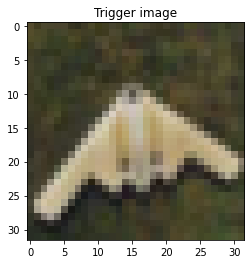

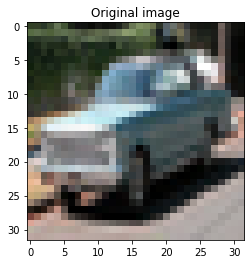

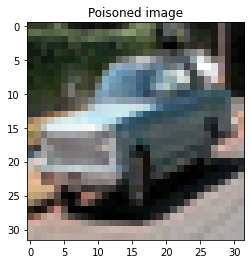

In [4]:
import matplotlib.pyplot as plt
plt.imshow(x_trigger[0].transpose([1,2,0])*(std+1e-7)+mean)
plt.title('Trigger image')
plt.show()

index_poisoned_example = np.where([np.any(p!=o) for (p,o) in zip(x_poison,x_train)])[0]
plt.imshow(x_train[index_poisoned_example[0]].transpose([1,2,0])*(std+1e-7)+mean)
plt.title('Original image')
plt.show()

plt.imshow(x_poison[index_poisoned_example[0]].transpose([1,2,0])*(std+1e-7)+mean)
plt.title('Poisoned image')
plt.show()


## Training with Poison Images

These attacks allow adversaries who can poison your dataset the ability to mislabel any particular target instance of their choosing without manipulating labels.

In [7]:
model_poisoned = create_model(x_poison, y_poison, epochs=80, x_trigger=x_trigger, y_trigger=y_trigger.argmax())
y_ = model_poisoned[0](torch.tensor(x_trigger, device=device, dtype=torch.float)).detach().cpu().numpy()

print("y_trigger:", y_trigger)
print("y_:", y_)

if np.argmax(y_trigger) == np.argmax(y_):
    print("Poisoning was successful.")
else:
    print("Poisoning failed.")

  1%|▏         | 1/80 [00:14<18:31, 14.07s/it, acc=0.376, target=0.0209]

0.020920968


  2%|▎         | 2/80 [00:28<18:17, 14.07s/it, acc=0.583, target=0.0154]

0.015409195


  4%|▍         | 3/80 [00:42<18:03, 14.07s/it, acc=0.682, target=0.0186]

0.018587798


  5%|▌         | 4/80 [00:56<17:49, 14.07s/it, acc=0.74, target=0.0369]

0.03688863


  6%|▋         | 5/80 [01:10<17:38, 14.12s/it, acc=0.788, target=0.0564]

0.056420334


  8%|▊         | 6/80 [01:24<17:26, 14.14s/it, acc=0.827, target=0.0481]

0.048127163


  9%|▉         | 7/80 [01:38<17:13, 14.16s/it, acc=0.861, target=0.0506]

0.050582413


 10%|█         | 8/80 [01:53<17:00, 14.17s/it, acc=0.879, target=0.059]

0.058958918


 11%|█▏        | 9/80 [02:07<16:46, 14.17s/it, acc=0.892, target=0.0673]

0.06726132


 12%|█▎        | 10/80 [02:21<16:30, 14.15s/it, acc=0.905, target=0.0562]

0.056229576


 14%|█▍        | 11/80 [02:35<16:15, 14.14s/it, acc=0.913, target=0.0715]

0.07147843


 15%|█▌        | 12/80 [02:49<16:01, 14.14s/it, acc=0.923, target=0.0874]

0.08737667


 16%|█▋        | 13/80 [03:03<15:47, 14.14s/it, acc=0.924, target=0.086]

0.08596856


 18%|█▊        | 14/80 [03:17<15:32, 14.13s/it, acc=0.931, target=0.123]

0.123355106


 19%|█▉        | 15/80 [03:31<15:18, 14.13s/it, acc=0.935, target=0.0836]

0.08357185


 20%|██        | 16/80 [03:46<15:04, 14.13s/it, acc=0.934, target=0.0984]

0.098448165


 21%|██▏       | 17/80 [04:00<14:49, 14.13s/it, acc=0.936, target=0.107]

0.10721302


 22%|██▎       | 18/80 [04:14<14:35, 14.12s/it, acc=0.938, target=0.126]

0.12556186


 24%|██▍       | 19/80 [04:28<14:21, 14.12s/it, acc=0.939, target=0.112]

0.11232751


 25%|██▌       | 20/80 [04:42<14:07, 14.12s/it, acc=0.941, target=0.0986]

0.09856177


 26%|██▋       | 21/80 [04:56<13:53, 14.12s/it, acc=0.941, target=0.072]

0.072005235


 28%|██▊       | 22/80 [05:10<13:39, 14.13s/it, acc=0.941, target=0.0941]

0.09408554


 29%|██▉       | 23/80 [05:24<13:24, 14.12s/it, acc=0.945, target=0.143]

0.14295644


 30%|███       | 24/80 [05:39<13:11, 14.13s/it, acc=0.942, target=0.0988]

0.098763734


 31%|███▏      | 25/80 [05:53<12:57, 14.14s/it, acc=0.944, target=0.107]

0.10666917


 32%|███▎      | 26/80 [06:07<12:43, 14.14s/it, acc=0.945, target=0.0918]

0.09183159


 34%|███▍      | 27/80 [06:21<12:29, 14.15s/it, acc=0.944, target=0.0902]

0.09021515


 35%|███▌      | 28/80 [06:35<12:15, 14.15s/it, acc=0.946, target=0.11]

0.11031617


 36%|███▋      | 29/80 [06:49<12:01, 14.15s/it, acc=0.947, target=0.0759]

0.07586657


 38%|███▊      | 30/80 [07:04<11:47, 14.16s/it, acc=0.946, target=0.152]

0.15231666


 39%|███▉      | 31/80 [07:18<11:33, 14.16s/it, acc=0.948, target=0.0835]

0.08345677


 40%|████      | 32/80 [07:32<11:19, 14.16s/it, acc=0.947, target=0.128]

0.12797007


 41%|████▏     | 33/80 [07:46<11:05, 14.16s/it, acc=0.946, target=0.132]

0.13184261


 42%|████▎     | 34/80 [08:00<10:51, 14.16s/it, acc=0.948, target=0.11]

0.11028243


 44%|████▍     | 35/80 [08:14<10:37, 14.16s/it, acc=0.947, target=0.13]

0.1295244


 45%|████▌     | 36/80 [08:29<10:23, 14.16s/it, acc=0.948, target=0.172]

0.172181


 46%|████▋     | 37/80 [08:43<10:08, 14.15s/it, acc=0.947, target=0.108]

0.108013004


 48%|████▊     | 38/80 [08:57<09:54, 14.14s/it, acc=0.948, target=0.138]

0.13825662


 49%|████▉     | 39/80 [09:11<09:39, 14.14s/it, acc=0.948, target=0.137]

0.13709758


 50%|█████     | 40/80 [09:25<09:25, 14.14s/it, acc=0.95, target=0.095]

0.095026456


 51%|█████▏    | 41/80 [09:39<09:11, 14.14s/it, acc=0.949, target=0.156]

0.15563437


 52%|█████▎    | 42/80 [09:53<08:56, 14.12s/it, acc=0.948, target=0.113]

0.11280523


 54%|█████▍    | 43/80 [10:07<08:41, 14.10s/it, acc=0.952, target=0.118]

0.118065126


 55%|█████▌    | 44/80 [10:21<08:27, 14.09s/it, acc=0.949, target=0.103]

0.10319721


 56%|█████▋    | 45/80 [10:35<08:13, 14.10s/it, acc=0.948, target=0.132]

0.1319594


 57%|█████▊    | 46/80 [10:50<07:59, 14.11s/it, acc=0.95, target=0.137]

0.1367653


 59%|█████▉    | 47/80 [11:04<07:45, 14.12s/it, acc=0.952, target=0.109]

0.10917406


 60%|██████    | 48/80 [11:18<07:31, 14.12s/it, acc=0.951, target=0.126]

0.12584516


 61%|██████▏   | 49/80 [11:32<07:17, 14.12s/it, acc=0.951, target=0.111]

0.11106715


 62%|██████▎   | 50/80 [11:46<07:03, 14.13s/it, acc=0.948, target=0.119]

0.11948199


 64%|██████▍   | 51/80 [12:00<06:49, 14.13s/it, acc=0.95, target=0.114]

0.114476986


 65%|██████▌   | 52/80 [12:14<06:35, 14.13s/it, acc=0.951, target=0.159]

0.15948537


 66%|██████▋   | 53/80 [12:28<06:21, 14.11s/it, acc=0.95, target=0.0977]

0.097685345


 68%|██████▊   | 54/80 [12:43<06:07, 14.12s/it, acc=0.952, target=0.161]

0.16091889


 69%|██████▉   | 55/80 [12:57<05:52, 14.12s/it, acc=0.95, target=0.118]

0.11816824


 70%|███████   | 56/80 [13:11<05:38, 14.12s/it, acc=0.95, target=0.117]

0.117391355


 71%|███████▏  | 57/80 [13:25<05:24, 14.12s/it, acc=0.95, target=0.12]

0.119514264


 72%|███████▎  | 58/80 [13:39<05:10, 14.12s/it, acc=0.952, target=0.0958]

0.095783554


 74%|███████▍  | 59/80 [13:53<04:56, 14.12s/it, acc=0.955, target=0.119]

0.11944448


 75%|███████▌  | 60/80 [14:07<04:42, 14.12s/it, acc=0.95, target=0.189]

0.18874319


 76%|███████▋  | 61/80 [14:21<04:28, 14.12s/it, acc=0.95, target=0.148]

0.14826103


 78%|███████▊  | 62/80 [14:36<04:13, 14.10s/it, acc=0.952, target=0.113]

0.11327739


 79%|███████▉  | 63/80 [14:50<03:59, 14.11s/it, acc=0.953, target=0.069]

0.06896717


 80%|████████  | 64/80 [15:04<03:45, 14.11s/it, acc=0.951, target=0.0911]

0.09106824


 81%|████████▏ | 65/80 [15:18<03:31, 14.11s/it, acc=0.951, target=0.122]

0.1224477


 82%|████████▎ | 66/80 [15:32<03:17, 14.12s/it, acc=0.951, target=0.141]

0.1405533


 84%|████████▍ | 67/80 [15:46<03:03, 14.12s/it, acc=0.953, target=0.13]

0.13029188


 85%|████████▌ | 68/80 [16:00<02:49, 14.12s/it, acc=0.953, target=0.127]

0.1267492


 86%|████████▋ | 69/80 [16:14<02:35, 14.10s/it, acc=0.952, target=0.122]

0.121668346


 88%|████████▊ | 70/80 [16:28<02:21, 14.11s/it, acc=0.953, target=0.164]

0.16406083


 89%|████████▉ | 71/80 [16:43<02:06, 14.11s/it, acc=0.954, target=0.15]

0.14967178


 90%|█████████ | 72/80 [16:57<01:52, 14.12s/it, acc=0.956, target=0.121]

0.12111224


 91%|█████████▏| 73/80 [17:11<01:38, 14.12s/it, acc=0.95, target=0.14]

0.13993573


 92%|█████████▎| 74/80 [17:25<01:24, 14.12s/it, acc=0.951, target=0.114]

0.11379288


 94%|█████████▍| 75/80 [17:39<01:10, 14.10s/it, acc=0.954, target=0.112]

0.112019755


 95%|█████████▌| 76/80 [17:53<00:56, 14.11s/it, acc=0.953, target=0.162]

0.16198677


 96%|█████████▋| 77/80 [18:07<00:42, 14.12s/it, acc=0.951, target=0.107]

0.10707213


 98%|█████████▊| 78/80 [18:21<00:28, 14.10s/it, acc=0.955, target=0.14]

0.13950746


 99%|█████████▉| 79/80 [18:35<00:14, 14.11s/it, acc=0.953, target=0.166]

0.16608614


100%|██████████| 80/80 [18:50<00:00, 14.13s/it, acc=0.95, target=0.199]


0.19921567
Final test accuracy: 91.694000
y_trigger: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
y_: [[-0.20934106  0.77485    -0.47768652  0.37470865 -0.41368857  0.153992
  -0.27345532  0.3594131  -0.4573476   0.16890174]]
Poisoning was successful.
